In [1]:
import kwant
import numpy as np
from cmath import exp
from math import pi
# For plotting
# %run matplotlib_setup.ipy
from matplotlib import pyplot
from ipywidgets import interact
import time

In [2]:
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

t=1.0
t_sc=1.0

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

def make_system(a=1, Delta=0.2, salt=13, U0=0.0,
                W=200, L=200, Wsc=80, Lsc=20, L_top=30, t_j=0.1, mu=0.6, mu_sc=2, phi=0):


    def hopping(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        # modulated hopping in y direction
#         H1=tinyarray.array([[-t*exp(1j * pi* phi * (xi + xj) * (yi - yj)),0],\
#                             [0,t*exp(-1j * pi* phi * (xi + xj) * (yi - yj))]])
#         # modulated hopping in x direction
        H1=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
        return H1
    
    def onsite(site, mu, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu + 4 * t)* tau_z
#         return  (4 * t - mu) * tau_z

    def onsite_sc(site, mu_sc, U0, Delta, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu_sc + 4 * t_sc)* tau_z+ Delta * tau_x
#         return  (4 * t_sc - mu_sc) * tau_z + Delta * tau_x

    
    lat = kwant.lattice.square(norbs=2)
    syst = kwant.Builder()
    syst[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    syst[(lat(x, y) for x in range(int(L/2-Lsc/2),int(L/2+Lsc/2) ) for y in range(Wsc))] = onsite_sc
    syst[lat.neighbors()] = hopping
#     syst[([lat(x, W-1),lat(x, 0)] for x in range(L))] = -t* tau_z
    

    def hopping_sc(site1, site2):
        return -t_sc*tau_z
    
    def inside_sc(hop):
        x, y = hop[0].tag
        return ( (int(L/2-Lsc/2)<x<int(L/2+Lsc/2) )  and (-1<y<Wsc) )

   
    # Modify only those hopings in x-direction that cross the branch cut
    def hops_inside_sc(syst):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(syst):
            if inside_sc(hop):
                yield hop
        for hop in kwant.builder.HoppingKind((0, 1), lat, lat)(syst):
            if inside_sc(hop):
                yield hop
    syst[hops_inside_sc] = hopping_sc

    def hopping_jn(site_i, site_j, t_j, phi):
        return -t_j*tau_z
#         xi, yi = site_i.pos
#         xj, yj = site_j.pos
#         # modulated hopping in x direction
#         H1=tinyarray.array([[-t_j*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
#                             [0,t_j*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
#         return H1

    def crosses_bdy(hop):
        x, y = hop[0].tag
        if x==int(L/2-Lsc/2) and y<=Wsc :
            return True
        elif x==int(L/2+Lsc/2) and y<=Wsc :
            return True
        elif y==Wsc and (int(L/2-Lsc/2) <=x< int(L/2+Lsc/2)):
            return True
        else:
            return False
        
    # Modify only those hopings in 
    def hops_across_bdy(syst):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(syst):
            if crosses_bdy(hop):
                yield hop
        for hop in kwant.builder.HoppingKind((0, 1), lat, lat)(syst):
            if crosses_bdy(hop):
                yield hop

    syst[hops_across_bdy] = hopping_jn
    
    def onsite_lead(site, mu):
        return  (- mu + 4 * t)* tau_z

    def hopping_lead(site1, site2):
        return -t*tau_z

    sym_left = kwant.TranslationalSymmetry((-1, 0))
    left_lead = kwant.Builder(sym_left, conservation_law=-tau_z, particle_hole=tau_y)
    left_lead[(lat(0, y) for y in range(0,W))] = onsite_lead
    left_lead[lat.neighbors()] = hopping
    syst.attach_lead(left_lead)
    syst.attach_lead(left_lead.reversed())

    return syst

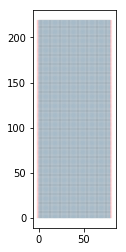

In [3]:
# def main():
Wsc=200
W=Wsc+20
Lsc=40
L=Lsc+40
syst = make_system(W=W, L=L, Wsc=Wsc, Lsc=Lsc)
# Check that the system looks as intended.
kwant.plot(syst)
# Finalize the system.
syst = syst.finalized()

(2, 35200)


/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: The plotted data contains 1.30% of values overflowing upper limit 0.501168 and 0.05% of values underflowing lower limit -0.0964902 
  del sys.path[0]


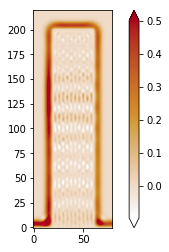

In [4]:
# plot_wf(syst,energy=0,params=[])
# plot_wf(syst,energy=0,params = dict(phi=0.05))
# plot_wf(syst,energy=0,params = dict(mu=-0.6,mu_sc=2.0,phi=0.05))
energy=0.0
params=dict(t_j=0.5,mu=0.11,mu_sc=0.6,phi=0.01,U0=0.,Delta=0.004,salt=10)
wfs = kwant.wave_function(syst, energy=energy, params=params)
scattering_wf = wfs(0)  # all scattering wave functions from lead 0
#     rplot=np.sum(abs(scattering_wf[:][:2])**2, axis=0)
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,::2])**2, axis=0)-np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
ind=0
print(scattering_wf.shape)
kwant.plotter.map(syst, abs(scattering_wf[ind,::2])**2-abs(scattering_wf[ind,1::2])**2);
# kwant.plotter.map(syst, abs(scattering_wf[ind,::2])**2);

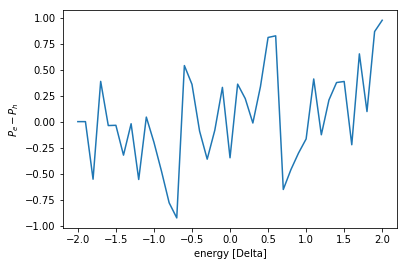

Finished, elapsed time = 95 sec


In [99]:
mu=0.1
mu_sc=1.5
phi=0.01
U0=0.5 # disorder strength
salt=13
Delta=0.02
t_j=0.5

def plot_conductance(syst, energies):
    # Compute conductance
    Pe = []
    Ph = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy,params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt))
        Pe.append(smatrix.transmission((1, 0), (0, 0)) )                    
        Ph.append(smatrix.transmission((1, 1), (0, 0)) )    

    pyplot.figure()
    pyplot.plot(np.array(energies)/Delta, np.array(Pe)-np.array(Ph))
#     pyplot.plot(energies, Ph)
#     pyplot.plot(energies, data)
    pyplot.xlabel("energy [Delta]")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()
    
E_list=np.arange(-20, 21)*Delta/10
t_timer=time.time()
# Compute and plot the conductance
plot_conductance(syst, energies=[E for E in E_list])
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

In [ ]:
mu_sc=1.5
phi=0.01
U0=0.5 # disorder strength
salt=13
Delta=0.02
t_j=0.5

def plot_conductance(syst, mu_sw):
    # Compute conductance
    Nrep=10
    vec=np.zeros((len(mu_sw),Nrep))
#     print(np.shape(vec))
    for salt in range(Nrep):
        print(salt, end='\r')
        for i_mu in range(len(mu_sw)):
            mu=mu_sw[i_mu]
            smatrix = kwant.smatrix(syst,energy=0,params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt))    
            # Conductance is N - R_ee + R_he
            vec[i_mu,salt]=(smatrix.transmission((1, 0), (0, 0)) -
                        smatrix.transmission((1, 1), (0, 0)))
#         vec=vec+data
#         print([np.shape(vec),np.shape(data)])
    
    cond_avg=np.mean(vec,axis=1)
    pyplot.figure()
    pyplot.plot(np.reshape(mu_sw,[len(mu_sw),1]), vec,'b')
    pyplot.plot(np.reshape(mu_sw,[len(mu_sw),1]), cond_avg,'r')
    pyplot.xlabel(r"$\mu [t]$")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()
    
# Compute and plot the conductance
plot_conductance(syst, mu_sw=[0.01 * i for i in range(5, 20)])